In [46]:
import cv2
import numpy as np
from skimage.measure import shannon_entropy
import pywt
import os
import pandas as pd

# ---------- Helper Functions for Color Conversion ----------
def convert_color_space(image, color_space):
    """
    Convert the input image to the specified color space.
    """
    if color_space == 'grayscale':
        return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif color_space == 'lab':
        return cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    elif color_space == 'yuv':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'hsv':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'rgb':
        return image  # No conversion needed
    else:
        raise ValueError(f"Unsupported color space: {color_space}")

# ---------- Noise Estimation Methods ----------
def variance_noise_estimation(image, color_space):
    if color_space == 'grayscale':
        channel = image
    elif color_space in ['lab', 'yuv']:
        channel = image[:, :, 0]  # Use luminance channel
    else:
        channel = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return np.var(channel)

def entropy_noise_estimation(image, color_space):
    if color_space == 'grayscale':
        channel = image
    elif color_space in ['lab', 'yuv']:
        channel = image[:, :, 0]  # Use luminance channel
    else:
        channel = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return shannon_entropy(channel)

def laplacian_noise_estimation(image, color_space):
    if color_space == 'grayscale':
        channel = image
    elif color_space in ['lab', 'yuv']:
        channel = image[:, :, 0]
    else:
        channel = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(channel, cv2.CV_64F)
    return np.mean(np.abs(laplacian))

def wavelet_noise_estimation(image, color_space):
    if color_space == 'grayscale':
        channel = image
    elif color_space in ['lab', 'yuv']:
        channel = image[:, :, 0]  # Use luminance channel
    else:
        channel = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    coeffs = pywt.wavedec2(channel, 'haar', level=2)
    high_freq_coeffs = coeffs[-1]
    return np.std(np.hstack(high_freq_coeffs))

# ---------- Noise Estimation Dispatcher ----------
def noise_estimation(image, color_space='rgb', method='variance'):
    converted_image = convert_color_space(image, color_space)
    if method == 'variance':
        return variance_noise_estimation(converted_image, color_space)
    elif method == 'entropy':
        return entropy_noise_estimation(converted_image, color_space)
    elif method == 'laplacian':
        return laplacian_noise_estimation(converted_image, color_space)
    elif method == 'wavelet':
        return wavelet_noise_estimation(converted_image, color_space)
    else:
        raise ValueError(f"Unsupported method: {method}")

# ---------- Calculate Ground Truth (GT) Noise ----------
def calculate_mean_difference(noisy_image, gt_image):
    return np.mean(noisy_image.astype('float32') - gt_image.astype('float32')) #np.mean(noisy_image-gt_image)

# ---------- Main Evaluation Script ----------
def evaluate_noise_estimation(noisy_images_dir, gt_images_dir, methods, color_spaces):
    results = []

    # Iterate through all images in the noisy and GT directories
    for img_name in os.listdir(noisy_images_dir):
        if img_name.endswith('.jpg'):
            noisy_image = cv2.imread(os.path.join(noisy_images_dir, img_name))
            gt_image = cv2.imread(os.path.join(gt_images_dir, img_name))
            
            # Compute the mean difference between noisy and GT image
            mean_diff = calculate_mean_difference(noisy_image, gt_image)
            
            for color_space in color_spaces:
                for method in methods:
                    # Estimate noise
                    noise_estimate = noise_estimation(noisy_image, color_space=color_space, method=method)
                    
                    # Append the results for each image, method, and color space
                    results.append({
                        'Image': img_name,
                        'Color Space': color_space,
                        'Method': method,
                        'Mean Difference': mean_diff,
                        'Noise Estimate': noise_estimate
                    })

    # Convert results into a DataFrame for better readability
    df = pd.DataFrame(results)
    return df

# ---------- Parameters for Evaluation ----------
noisy_images_dir = '/Users/abriil/Uni/master/C1/data/qsd1_w3'
gt_images_dir = '/Users/abriil/Uni/master/C1/data/qsd1_w3/non_augmented'

methods = ['variance', 'entropy', 'laplacian', 'wavelet']
color_spaces = ['rgb', 'grayscale', 'lab', 'yuv']

# Run evaluation
df_results = evaluate_noise_estimation(noisy_images_dir, gt_images_dir, methods, color_spaces)

# Output the results for each color space
for color_space in color_spaces:
    print(f"Results for Color Space: {color_space}")
    print(df_results[df_results['Color Space'] == color_space].to_string(index=False))


Results for Color Space: rgb
    Image Color Space    Method  Mean Difference  Noise Estimate
00025.jpg         rgb  variance        -0.235887     1082.658312
00025.jpg         rgb   entropy        -0.235887        6.533563
00025.jpg         rgb laplacian        -0.235887        6.741982
00025.jpg         rgb   wavelet        -0.235887        5.560454
00019.jpg         rgb  variance        -1.263143      447.251139
00019.jpg         rgb   entropy        -1.263143        6.177124
00019.jpg         rgb laplacian        -1.263143        5.669959
00019.jpg         rgb   wavelet        -1.263143        3.806172
00018.jpg         rgb  variance         1.921858      779.633622
00018.jpg         rgb   entropy         1.921858        6.779677
00018.jpg         rgb laplacian         1.921858       38.615125
00018.jpg         rgb   wavelet         1.921858       14.668090
00024.jpg         rgb  variance         0.000000     2508.888271
00024.jpg         rgb   entropy         0.000000        6.586

In [43]:
df_results['Mean Difference'].min()

-1.2631428

In [44]:
df_results['Mean Difference'].max()

9.125618

/var/folders/5y/ljztfs697fqf9rvmq2qtpg3m0000gn/T/ipykernel_16263/2351303653.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Normalized Noise Estimate', data=df_rgb, palette='Set2')
/opt/anaconda3/envs/prova/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


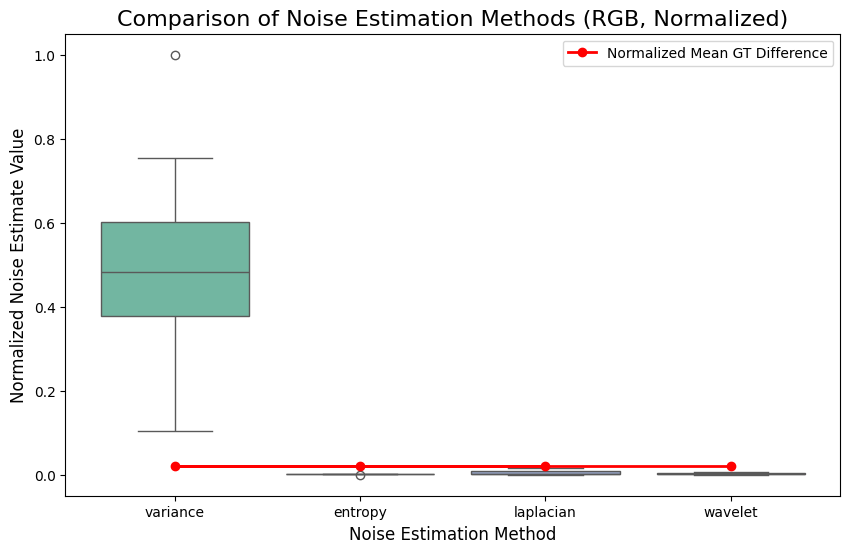

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Filter results for RGB color space
df_rgb = df_results[df_results['Color Space'] == 'lab'].copy()

# Normalize the 'Noise Estimate' using Min-Max scaling
scaler = MinMaxScaler()
df_rgb['Normalized Noise Estimate'] = scaler.fit_transform(df_rgb[['Noise Estimate']])

# Initialize the plot
plt.figure(figsize=(10, 6))

# Create a box plot for normalized noise estimates for each method in RGB space
sns.boxplot(x='Method', y='Normalized Noise Estimate', data=df_rgb, palette='Set2')

# Overlay the mean ground truth difference, also normalize it using Min-Max scaling
gt_means = df_rgb.groupby('Method')['Mean Difference'].mean()
gt_means_normalized = scaler.transform(gt_means.values.reshape(-1, 1)).flatten()

# Plot the normalized mean ground truth difference
plt.plot(gt_means.index, gt_means_normalized, color='red', marker='o', linestyle='-', label='Normalized Mean GT Difference', linewidth=2)

# Adding labels and title
plt.title('Comparison of Noise Estimation Methods (RGB, Normalized)', fontsize=16)
plt.xlabel('Noise Estimation Method', fontsize=12)
plt.ylabel('Normalized Noise Estimate Value', fontsize=12)
plt.legend(loc='upper right')

# Show the plot
plt.show()


In [28]:

# Assuming df is the original dataframe with columns 'Image, Color Space, Method, Mean Difference, Noise Estimate'
df = df_results
# Pivot the table to get methods as columns with their corresponding noise estimate values
df_pivot = df_results[df_results['Color Space'] == 'lab'].copy()

# Reset the index to bring 'Image' and 'Color Space' back as columns
df_pivot.reset_index(inplace=True)

# Add the 'Mean Difference' column back to the pivoted dataframe
df_pivot['Mean Difference'] = df.groupby(['Image', 'Color Space'])['Mean Difference'].mean().values

# Display the final pivoted table
print(df_pivot)



     index      Image Color Space     Method  Mean Difference  Noise Estimate
0        8  00025.jpg         lab   variance       103.186640     1119.739855
1        9  00025.jpg         lab    entropy       103.186640        6.530015
2       10  00025.jpg         lab  laplacian       103.186640        6.938913
3       11  00025.jpg         lab    wavelet       103.186640        5.795117
4       24  00019.jpg         lab   variance         0.000000      624.490902
..     ...        ...         ...        ...              ...             ...
115    459  00000.jpg         lab    wavelet       142.033719       11.130218
116    472  00028.jpg         lab   variance       118.123865     4035.561721
117    473  00028.jpg         lab    entropy       118.123865        7.720189
118    474  00028.jpg         lab  laplacian       118.123865       58.118194
119    475  00028.jpg         lab    wavelet       118.123865       28.962560

[120 rows x 6 columns]


In [30]:


# Assuming df is the original dataframe with columns 'Image, Color Space, Method, Mean Difference, Noise Estimate'
df = df_results[df_results['Color Space'] == 'lab'].copy()
# Pivot the table to create a column for each method
df_pivot = df.pivot(index=['Image', 'Color Space'], columns='Method', values='Noise Estimate')

# Reset the index to convert 'Image' and 'Color Space' back to columns
df_pivot.reset_index(inplace=True)

# Add the 'Mean Difference' column back to the pivoted dataframe (take the first value as it's constant per image)
df_pivot['Mean Difference'] = df.groupby(['Image', 'Color Space'])['Mean Difference'].first().values

# Display the final pivoted table
print(df_pivot)


Method      Image Color Space   entropy  laplacian     variance    wavelet  \
0       00000.jpg         lab  7.433010  15.781139  3046.152436  11.130218   
1       00001.jpg         lab  6.658297   7.056067  2249.360430   6.784187   
2       00002.jpg         lab  5.557531   7.388216   421.178442   7.986694   
3       00003.jpg         lab  7.186300  11.304327  1520.697000   8.041041   
4       00004.jpg         lab  7.158725   8.999818  1924.402845   6.907881   
5       00005.jpg         lab  7.651856  43.566029  2632.593714  17.265427   
6       00006.jpg         lab  7.538504  70.227810  2334.450346  24.892697   
7       00007.jpg         lab  7.198499   9.309635  2096.804681   9.374096   
8       00008.jpg         lab  6.752351   6.687900  1837.910616   7.094454   
9       00009.jpg         lab  7.100975  24.817761  2911.723525  14.255440   
10      00010.jpg         lab  7.298650  10.260432  1976.223030   7.744077   
11      00011.jpg         lab  6.944850  12.812798  1101.058272 

In [41]:
# Assuming df_pivot is the pivoted DataFrame with the desired columns

# Select the columns for which we want to compute the correlation
columns_to_correlate = ['entropy', 'laplacian', 'variance', 'wavelet', 'Mean Difference']

# Compute the correlation matrix
correlation_matrix = df_pivot[columns_to_correlate].corr()

# Display the correlation of each method with respect to 'Mean Difference'
correlation_with_gt = correlation_matrix['Mean Difference'].drop('Mean Difference')

# Print the correlation values
print(correlation_with_gt)


Method
entropy     -0.162831
laplacian    0.234877
variance    -0.095315
wavelet      0.138217
Name: Mean Difference, dtype: float64


In [5]:

# Function to compute and return the mean absolute difference
def compute_mean_difference(image1, image2):
    """difference = image1.astype(np.float32) - image2.astype(np.float32)
    mean_diff = np.mean(np.abs(difference))"""
    return np.mean(image1-image2)

# Directories containing the noisy images and the ground truth images
noisy_images_dir = '/Users/abriil/Uni/master/C1/data/qsd1_w3'
gt_images_dir = '/Users/abriil/Uni/master/C1/data/qsd1_w3/non_augmented'

# List to store results for each image
results = []

# Process all images in the folder
for img_name in os.listdir(noisy_images_dir):
    if img_name.endswith('.jpg') or img_name.endswith('.png'):
        # Load noisy image and corresponding ground truth image
        noisy_image_path = os.path.join(noisy_images_dir, img_name)
        gt_image_path = os.path.join(gt_images_dir, img_name)

        noisy_image = cv2.imread(noisy_image_path)
        gt_image = cv2.imread(gt_image_path)

        # Ensure both images are loaded correctly
        if noisy_image is None or gt_image is None:
            print(f"Error loading {img_name}")
            continue

        # 1. Calculate the difference before filtering
        mean_diff_before = compute_mean_difference(noisy_image, gt_image)

        gb_img = cv2.GaussianBlur(noisy_image, (5, 5), 0)
        gb_diff = compute_mean_difference(gb_img, gt_image)

        mb_img = cv2.medianBlur(noisy_image, 5)
        mb_diff = compute_mean_difference(mb_img, gt_image)

        bb_img = cv2.bilateralFilter(noisy_image, 9, 75, 75)
        bb_diff = compute_mean_difference(bb_img, gt_image)

        nlm_img = cv2.fastNlMeansDenoisingColored(noisy_image, None, 10, 10, 7, 21)
        nlm_diff = compute_mean_difference(nlm_img, gt_image)

        # Store the results for this image
        results.append({
            'Image': img_name,
            'Mean Difference (Before)': mean_diff_before,
            'Gaussian Blur': gb_diff,
            'Median Blur': mb_diff,
            'Bilateral Filter': bb_diff,
            'NLM': nlm_diff
        })

# Convert results to a pandas DataFrame for better organization and analysis
import pandas as pd

df_results = pd.DataFrame(results)

# Display the final DataFrame with the differences for all images
print(df_results)

# Optionally, save the results to a CSV file
df_results.to_csv('filtering_comparison_results.csv', index=False)


        Image  Mean Difference (Before)  Gaussian Blur  Median Blur  \
0   00025.png                  0.000000       1.493718     0.086890   
1   00019.png                  0.000000       4.638274     0.126228   
2   00025.jpg                 99.085385     117.769378   117.219386   
3   00019.jpg                146.511343     144.985149   145.422881   
4   00018.jpg                116.118997      84.518609    98.025325   
5   00024.jpg                  0.000000      83.865984    77.241829   
6   00018.png                  0.000000       1.903227     0.033429   
7   00024.png                  0.000000       4.709418     0.039967   
8   00026.png                  0.000000       1.578803     0.020662   
9   00026.jpg                123.411395     123.628190   123.922670   
10  00027.jpg                  0.000000     114.632964   108.884093   
11  00027.png                  0.000000       2.042868     0.020286   
12  00023.png                  0.000000       2.498462     0.017187   
13  00

In [6]:
df_results

,Image,Mean Difference (Before),Gaussian Blur,Median Blur,Bilateral Filter,NLM
0,00025.png,0.000000,1.493718,0.086890,1.298039,254.613904
1,00019.png,0.000000,4.638274,0.126228,3.033480,253.349573
2,00025.jpg,99.085385,117.769378,117.219386,120.904145,129.055584
3,00019.jpg,146.511343,144.985149,145.422881,143.083383,156.487215
4,00018.jpg,116.118997,84.518609,98.025325,93.739867,89.243769
5,00024.jpg,0.000000,83.865984,77.241829,93.185436,124.191022
6,00018.png,0.000000,1.903227,0.033429,1.253815,254.281264
7,00024.png,0.000000,4.709418,0.039967,2.682949,253.259614
8,00026.png,0.000000,1.578803,0.020662,1.005037,254.403852
9,00026.jpg,123.411395,123.628190,123.922670,124.719636,134.387345


In [9]:
#df_results.drop(columns=['Image']).corr()

,Mean Difference (Before),Gaussian Blur,Median Blur,Bilateral Filter,NLM
Mean Difference (Before),1.000000,0.789385,0.826408,0.765135,-0.667601
Gaussian Blur,0.789385,1.000000,0.994333,0.996118,-0.920557
Median Blur,0.826408,0.994333,1.000000,0.993911,-0.931536
Bilateral Filter,0.765135,0.996118,0.993911,1.000000,-0.946538
NLM,-0.667601,-0.920557,-0.931536,-0.946538,1.000000
